In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import os
from torchvision.transforms import Normalize, Compose, ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy import signal
from skimage.metrics import structural_similarity as ssim
from IPython.display import clear_output
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize, Compose, ToTensor
from tqdm import tqdm

In [2]:
!pip install names_generator

In [3]:
from names_generator import generate_name

In [4]:
base_path = "/home/diya/Projects/super_resolution/"
working_dir = "/home/diya/Projects/super_resolution/"
input_path = base_path + "dataset/"
output_path = working_dir + "outputs/blended_fno/"

# create directories for checkpoints and logs
log_dir = output_path + "logs/"
checkpoint_dir = output_path + "ckpt/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [5]:
train_df = pd.read_csv(input_path + "train.csv")
val_df = pd.read_csv(input_path + "val.csv")
test_df = pd.read_csv(input_path + "test.csv")

In [6]:
train_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


In [7]:
val_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,6763087613503343044,RHO_kgm-3_id6763087613503343044.dat,UX_ms-1_id6763087613503343044.dat,UY_ms-1_id6763087613503343044.dat,UZ_ms-1_id6763087613503343044.dat
1,7184356030387874174,RHO_kgm-3_id7184356030387874174.dat,UX_ms-1_id7184356030387874174.dat,UY_ms-1_id7184356030387874174.dat,UZ_ms-1_id7184356030387874174.dat
2,7026493720303378708,RHO_kgm-3_id7026493720303378708.dat,UX_ms-1_id7026493720303378708.dat,UY_ms-1_id7026493720303378708.dat,UZ_ms-1_id7026493720303378708.dat
3,5093314759039638268,RHO_kgm-3_id5093314759039638268.dat,UX_ms-1_id5093314759039638268.dat,UY_ms-1_id5093314759039638268.dat,UZ_ms-1_id5093314759039638268.dat
4,-2499630993713878664,RHO_kgm-3_id-2499630993713878664.dat,UX_ms-1_id-2499630993713878664.dat,UY_ms-1_id-2499630993713878664.dat,UZ_ms-1_id-2499630993713878664.dat


In [8]:
test_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-657116647631363807,RHO_kgm-3_id-657116647631363807.dat,UX_ms-1_id-657116647631363807.dat,UY_ms-1_id-657116647631363807.dat,UZ_ms-1_id-657116647631363807.dat
1,7483162365939134796,RHO_kgm-3_id7483162365939134796.dat,UX_ms-1_id7483162365939134796.dat,UY_ms-1_id7483162365939134796.dat,UZ_ms-1_id7483162365939134796.dat
2,-6212758420087317096,RHO_kgm-3_id-6212758420087317096.dat,UX_ms-1_id-6212758420087317096.dat,UY_ms-1_id-6212758420087317096.dat,UZ_ms-1_id-6212758420087317096.dat
3,-1825935182480952214,RHO_kgm-3_id-1825935182480952214.dat,UX_ms-1_id-1825935182480952214.dat,UY_ms-1_id-1825935182480952214.dat,UZ_ms-1_id-1825935182480952214.dat
4,-1859240836295259171,RHO_kgm-3_id-1859240836295259171.dat,UX_ms-1_id-1859240836295259171.dat,UY_ms-1_id-1859240836295259171.dat,UZ_ms-1_id-1859240836295259171.dat


Index:443


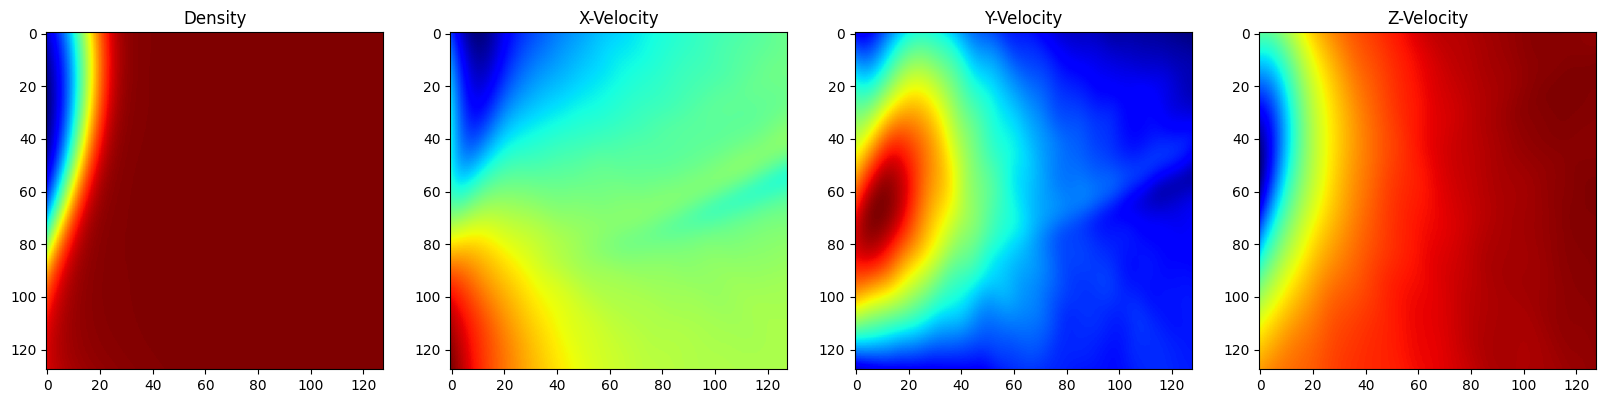

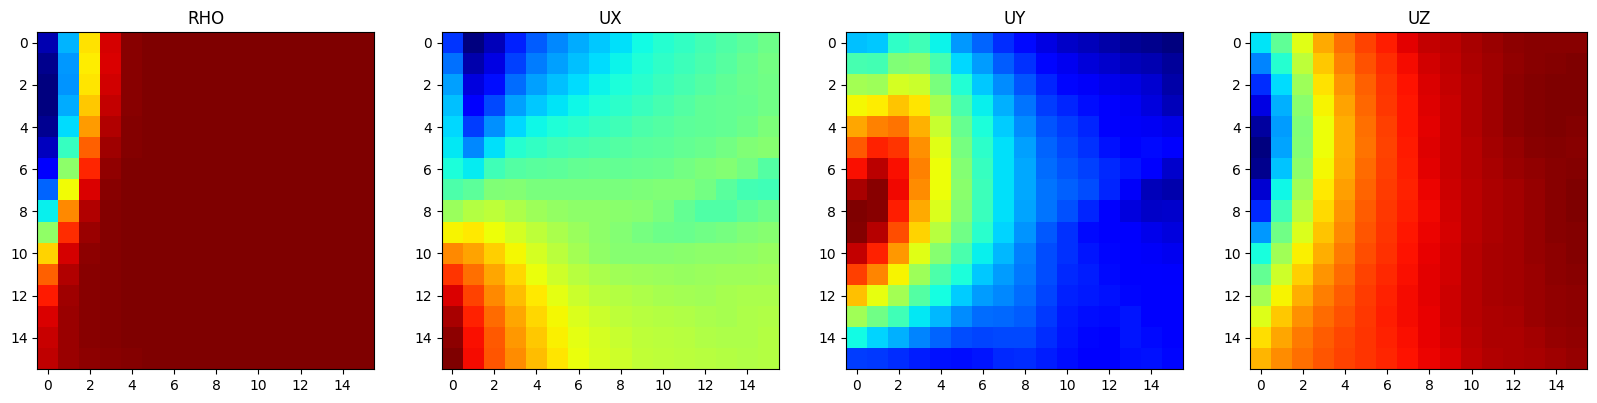

In [9]:
idx = np.random.choice(range(len(train_df)))
print(f"Index:{idx}")
data_path = input_path + "flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')
plt.show()

HR_X = np.concatenate([RHO.reshape(128, 128, 1), UX.reshape(128, 128, 1),
                       UY.reshape(128, 128, 1), UZ.reshape(128, 128, 1)], axis=-1)

# plot LR features

data_path = input_path + "flowfields/LR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

LR_X = np.concatenate([RHO.reshape(16, 16, 1), UX.reshape(16, 16, 1),
                       UY.reshape(16, 16, 1), UZ.reshape(16, 16, 1)], axis=-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')
plt.show()

In [10]:
class FlowFieldDataset(Dataset):
    def __init__(self, input_path, mode):
        assert mode in ["train", "val", "test"]
        self.mode = mode
        self.csv_file = pd.read_csv(input_path + f"{mode}.csv")
        if mode == "test":
            self.csv_file = pd.read_csv(input_path + f"{mode}.csv")
        self.LR_path = input_path + "flowfields/LR/" + mode
        self.HR_path = input_path + "flowfields/HR/" + mode

        self.mean = np.array([0.24, 28.0, 28.0, 28.0])
        self.std = np.array([0.068, 48.0, 48.0, 48.0])

    def transform(self, x):
        return Compose([ToTensor(), Normalize(self.mean, self.std, inplace=True)])(x)

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # input
        if self.mode == "test":
            id = self.csv_file["id"][idx]
            rho_i = np.fromfile(self.LR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(16, 16)
            ux_i = np.fromfile(self.LR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(16, 16)
            uy_i = np.fromfile(self.LR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(16, 16)
            uz_i = np.fromfile(self.LR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(16, 16)
            X = np.stack([rho_i, ux_i, uy_i, uz_i], axis=2)
            return id, self.transform(X)

        rho_i = np.fromfile(self.LR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(16, 16)
        ux_i = np.fromfile(self.LR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(16, 16)
        uy_i = np.fromfile(self.LR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(16, 16)
        uz_i = np.fromfile(self.LR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(16, 16)
        # output
        rho_o = np.fromfile(self.HR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(128, 128)
        ux_o = np.fromfile(self.HR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(128, 128)
        uy_o = np.fromfile(self.HR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(128, 128)
        uz_o = np.fromfile(self.HR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(128, 128)
        X = np.stack([rho_i, ux_i, uy_i, uz_i], axis=2)
        Y = np.stack([rho_o, ux_o, uy_o, uz_o], axis=2)
        return self.transform(X), self.transform(Y)



In [11]:
num_filters = 64*4
num_of_residual_blocks = 16
batch_size = 256

train_dataset = FlowFieldDataset(input_path=input_path, mode="train")
val_dataset = FlowFieldDataset(input_path=input_path, mode="val")
test_dataset = FlowFieldDataset(input_path=input_path, mode="test")
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, pin_memory=False)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size=3):
        super(ResNetBlock, self).__init__()
        self.resnet_block = torch.nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_filters, num_filters, kernel_size, padding="same")
        )
        self.input = nn.Sequential()

    def forward(self, x):
        inp = self.input(x)
        x = self.resnet_block(x)
        return x + inp

class Model(nn.Module):
    def __init__(
        self, in_channels=4, factor=2, scale=3, num_of_residual_blocks=16, num_filters=64, kernel_size=3, **kwargs
    ):
        super().__init__()
        self.num_of_residual_blocks = num_of_residual_blocks
        self.scale = scale
        self.factor = factor
        self.in_channels = in_channels
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        
        # Calculate total upscaling factor
        self.total_scale = factor ** scale
        
        self.resnet_input = nn.Conv2d(in_channels, num_filters, 1, padding="same")
        
        self.res_blocks = nn.Sequential(
            *[
                ResNetBlock(
                    in_channels=in_channels,
                    num_filters=num_filters,
                    kernel_size=kernel_size,
                )
            ]
            * num_of_residual_blocks
        )
        
        # Upsampling layers after residual blocks
        self.upsample = nn.Sequential(
            *[
                nn.Conv2d(num_filters, num_filters * (factor**2), kernel_size, padding="same", **kwargs),
                nn.PixelShuffle(upscale_factor=factor),
                nn.ReLU(inplace=True)
            ]
            * scale
        )
        
        self.resnet_out = nn.Conv2d(self.num_filters, self.num_filters, self.kernel_size, padding="same")
        self.output_layer = nn.Conv2d(num_filters, in_channels, 3, padding="same")

    def forward(self, x):
        # Bicubic upsampling of input
        bicubic_upsampled = F.interpolate(
            x, 
            scale_factor=self.total_scale, 
            mode='bicubic', 
            align_corners=False
        )
        
        # Process through the network
        x = self.resnet_input(x)
        x_res = self.res_blocks(x)
        x_res = self.resnet_out(x_res)
        out = x + x_res
        out = self.upsample(out)
        network_output = self.output_layer(out)
        
        # Combine network output with bicubic upsampling
        return network_output + bicubic_upsampled

In [13]:
ckpt_name = f"{generate_name()}"
num_epochs = 100
learning_rate = 1e-3
hyper_parameters = {"num_epochs": num_epochs, "learning_rate":learning_rate}

config = ProjectConfiguration(project_dir=working_dir, logging_dir=log_dir+ckpt_name)

model = Model()
loss_fn = torch.nn.MSELoss()
optimizer = Adam(params=model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer=optimizer)

accelerator = Accelerator(log_with="tensorboard", project_config=config)
accelerator.init_trackers(log_dir+ckpt_name, config=hyper_parameters)
model, optimizer, train_dataloader, val_dataloader, test_dataloader, scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, test_dataloader, scheduler
)


# Register the LR scheduler
accelerator.register_for_checkpointing(scheduler)
# Save the starting state

accelerator.save_state(output_dir=checkpoint_dir+ckpt_name)

2025-02-06 11:57:15.376073: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 11:57:15.382240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 11:57:15.389889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 11:57:15.392167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 11:57:15.398319: I tensorflow/core/platform/cpu_feature_guar

PosixPath('/home/diya/Projects/super_resolution/outputs/blended_fno/ckpt/blissful_dijkstra')

In [14]:
def visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/training_viz"):
    """
    Visualize a batch of inputs, outputs, and targets during training.
    
    Args:
        inputs: Input tensor [B, C, H, W]
        outputs: Model output tensor [B, 4, H, W]
        targets: Target tensor [B, 4, H, W]
        epoch: Current epoch number
        step: Current step number
        save_dir: Directory to save visualizations
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Take first sample from batch
    sample_idx = 0
    
    # Create figure
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
    
    # Plot inputs (if different from targets)
    for i in range(4):
        im = axs[0, i].imshow(inputs[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[0, i].set_title(f'Input {titles[i]}')
        axs[0, i].set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
        axs[0, i].set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
    
    # Plot model outputs
    for i in range(4):
        im = axs[1, i].imshow(outputs[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[1, i].set_title(f'Predicted {titles[i]}')
        axs[1, i].set_xticks([0, 20, 40, 60, 80, 100, 120])
        axs[1, i].set_yticks([0, 20, 40, 60, 80, 100, 120])
    
    # Plot targets
    for i in range(4):
        im = axs[2, i].imshow(targets[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[2, i].set_title(f'Target {titles[i]}')
        axs[2, i].set_xticks([0, 20, 40, 60, 80, 100, 120])
        axs[2, i].set_yticks([0, 20, 40, 60, 80, 100, 120])
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/epoch_{epoch}_step_{step}.png")
    plt.close()
    #plt.show()

In [15]:
progress_bar = tqdm(range(num_epochs))
for epoch in range(num_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        # with torch.autograd.set_detect_anomaly(True):
        optimizer.zero_grad()
        accelerator.backward(loss)
        # loss.backward(retain_graph=True)
        optimizer.step()
        #visualize_batch(inputs, outputs, targets, epoch, step)
        progress_bar.set_description(f"epoch : {epoch} | loss : {loss.detach().cpu()}")
        accelerator.log({"epoch": epoch, "train_loss":loss.detach().cpu()}, step=step)
        
    scheduler.step(loss.detach().cpu())
    
    model.eval()
    for step, batch in enumerate(val_dataloader):
        inputs, targets = batch
        outputs = model(inputs)
        val_loss = F.mse_loss(outputs, targets)
        if(step == 5):
            visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/validation_viz")
        progress_bar.set_description(f"epoch : {epoch} | val_loss : {val_loss.detach().cpu()}")
        progress_bar.update(1)
        accelerator.log({"epoch": epoch, "val_loss":val_loss.detach().cpu()}, step=step)
        
accelerator.end_training()

epoch : 99 | val_loss : 0.009625006467103958: 100%|██████████| 100/100 [01:46<00:00,  1.01it/s]

In [19]:
# Visualize the LR and HR of sample 1 of training dataset

model.eval()
for step, batch in enumerate(train_dataloader):
    inputs, targets = batch
    outputs = model(inputs)
    visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/training_viz")
    
# Visualize the LR and HR of sample 1 of validation dataset

model.eval() # Set model to evaluation mode
for step, batch in enumerate(val_dataloader):
    inputs, targets = batch
    outputs = model(inputs)
    visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/validation_viz")


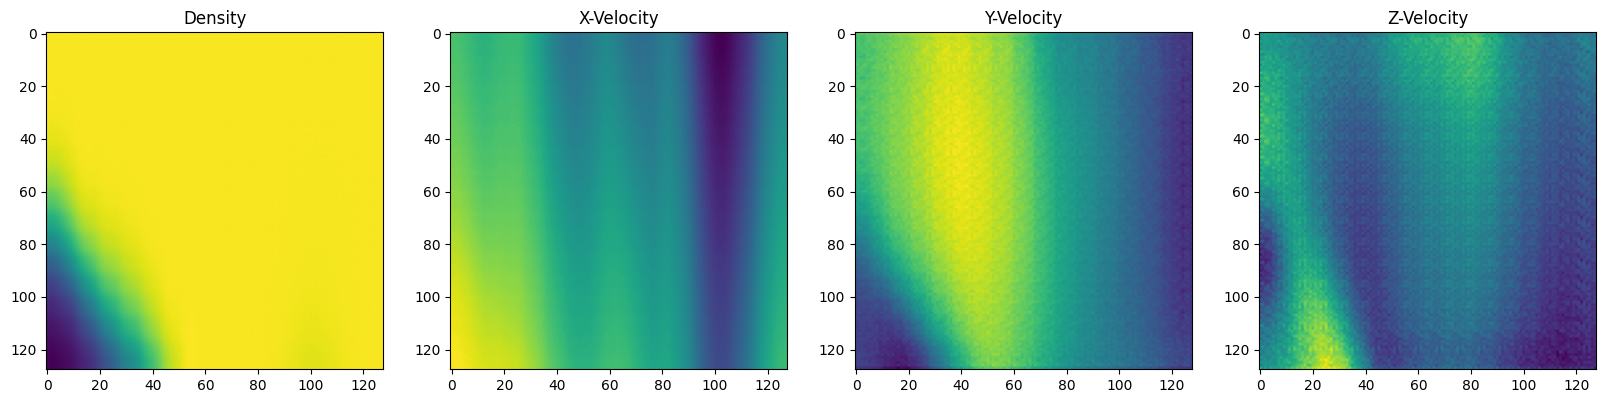

In [17]:
# Visualize the model predictions on the training set
# make a single plot with 4 subplots for each channel

model.eval()

for idx, (id, batch) in enumerate(test_dataloader):
    inputs = batch
    outputs = model(inputs)
    outputs = outputs.squeeze(0).detach().cpu().numpy()
    inputs = inputs.squeeze(0).detach().cpu().numpy()
    break

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
for i in range(4):
    axs[i].imshow(outputs[i], cmap='viridis')
    axs[i].set_title(titles[i])
plt.show()


